# GDL for main graph rewiring and metrics comparison

## Import libraries

In [1]:
import sys
print(sys.executable)
from pathlib import Path
import torch
import torch_geometric
print(torch.__version__)
print(torch_geometric.__version__)

import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
# from GraphRicciCurvature.FormanRicci import FormanRicci

import networkx as nx
import numpy as np
from scipy.sparse.csgraph import laplacian
from scipy.linalg import pinv, eigvalsh

from utils.load_data import *
from evaluation.metrics import *
from evaluation.metrics_distance import *
from evaluation.curvature import *
from visualization.plots import *
from visualization.networkx_plot import *
from analysis.utils import *


/media/alexandre/morespace/data/amgb20/CAM_venv/bin/python


/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:87: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_scatter/_scatter_cpu.so: undefined symbol: _ZN2at23SavedTensorDefaultHooks11set_tracingEb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/media/alexandre/morespace/data/amgb20/CAM_venv/lib/python3.10/site-packages/torch_geometric/typing.py:125: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcudart.so.12: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


2.4.0+cpu
2.7.0


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Rewiring our graphs

🚩 We need to respect the experimental details of hyperparameters describe on page 15

## Dynamic Graph Rewiring Method Code

In [ ]:
from ipywidgets import widgets, Tab, VBox, Output

dataset_names = ["MUTAG"]  # Default dataset selection
REWIRING_METHOD = ["FOSR"]   # Default rewiring method
ENTIRE_GRAPH = True    # Default entire graph selection
metrics = "Normal"    
show = True     

output = Output()  

data = widgets.Dropdown(
    options=["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"],
    value="MUTAG",
    description="Dataset:"
)

rewired_method = widgets.Dropdown(
    options=["BORF", "SDRF", "FOSR", "DES", "PPR", "LASER", "UNREWIRED"],
    value="BORF",
    description="Rewiring Method:"
)

entire_graph = widgets.Checkbox(
    value=True,
    description="Entire Graph"
)


metric = widgets.Dropdown(
    options=["Distance", "Normal"],
    value="Normal",
    description="Metrics:"
)

show_plots = widgets.Checkbox(
    value=True,
    description="Show plots"
)


def update_dataset(change):
    global dataset_names
    dataset_names = [change["new"]]
    with output:
        output.clear_output()
        print(f"Dataset Selected: {dataset_names}")

def update_rewiring_method(change):
    global REWIRING_METHOD
    REWIRING_METHOD = [change["new"]]
    with output:
        output.clear_output()
        print(f"Rewiring Method Selected: {REWIRING_METHOD}")

def update_entire_graph(change):
    global ENTIRE_GRAPH
    ENTIRE_GRAPH = change["new"]
    with output:
        output.clear_output()
        print(f"Entire Graph Selected: {ENTIRE_GRAPH}")

def update_show_plot(change):
    global show
    show = change["new"]
    with output:
        output.clear_output()
        print(f"Showing plots Selected: {show}")

def update_metrics(change):
    global metrics
    metrics = change["new"]
    with output:
        output.clear_output()
        print(f"Metrics Selected: {metrics}")


data.observe(update_dataset, names="value")
rewired_method.observe(update_rewiring_method, names="value")
entire_graph.observe(update_entire_graph, names="value")
show_plots.observe(update_show_plot, names="value")
metric.observe(update_metrics, names="value")


tab_contents = [
    VBox([data]),
    VBox([rewired_method]),
    VBox([entire_graph]),
    VBox([metric]),
    VBox([show_plots])
]

tab = Tab(children=tab_contents)

# Set tab titles
for i, title in enumerate(["Dataset", "Rewiring Method", "Entire Graph", "Metrics", "Show Plots"]):
    tab.set_title(i, title)

display(tab, output)


Output()

In [11]:

print(f"Selected dataset: {dataset_names}")
print(f"Selected rewiring method: {REWIRING_METHOD}")
print(f"Selected entire graph: {ENTIRE_GRAPH}")
print(f"Selected metrics: {metrics}")
print(f"Selected show plots: {show}")

Selected dataset: ['MUTAG']
Selected rewiring method: ['SDRF']
Selected entire graph: True
Selected metrics: Normal
Selected show plots: True


## Playground

⚠️ Warning: 'IMDB-BINARY' not found. Did you mean 'IMDB-BINARY'?
✅ Dataset IMDB-BINARY already exists. Loading from disk...
✅ Converted 1000 graphs from IMDB-BINARY into NetworkX format.
Rewiring methods being used: SDRF

🚀 Processing dataset: IMDB-BINARY


  0%|          | 0/1000 [00:00<?, ?it/s]/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/rewiring/sdrf/sdrf.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_edge_index = torch.tensor(new_edge_index)
/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/rewiring/sdrf/sdrf.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_edge_index = torch.tensor(new_edge_index)
/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/rewiring/sdrf/sdrf.py:278: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.t

Index with largest curvature difference: 650 difference= 7.826751592356688


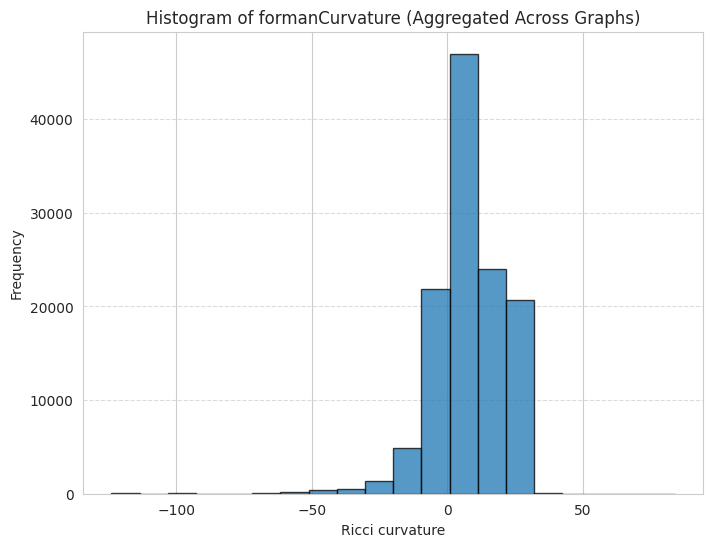

/media/alexandre/morespace/University of Cambridge/L65/L65-Mini-Project/visualization/networkx_plot.py:221: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.07, 0, 1, 1])


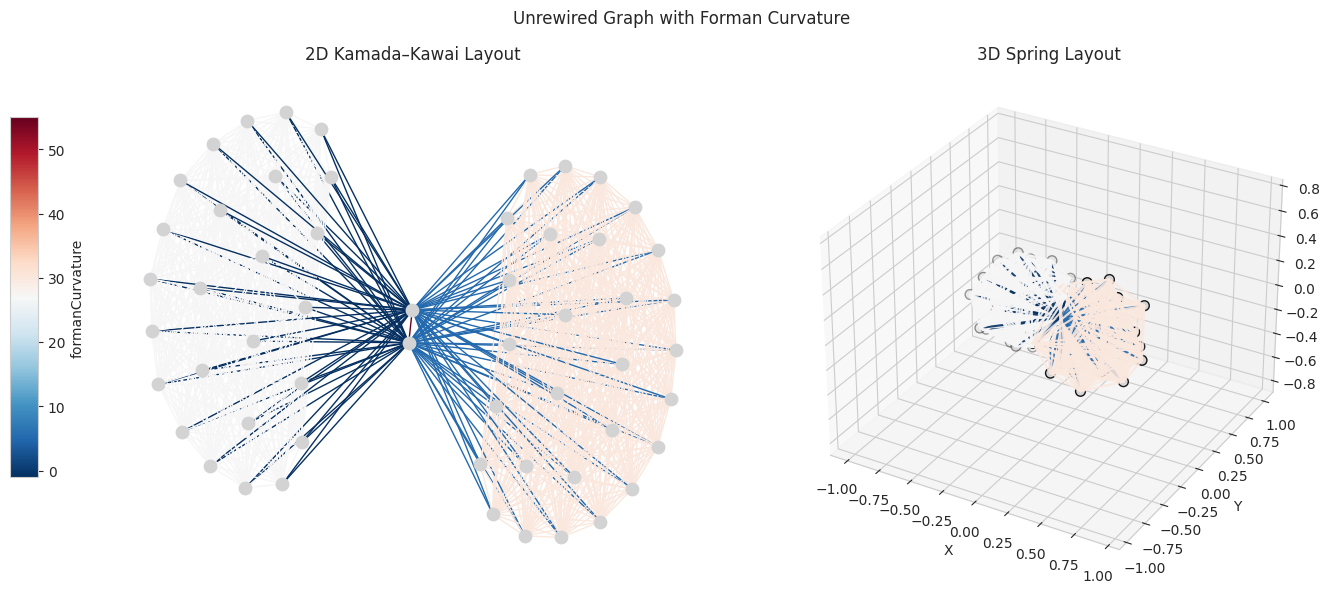

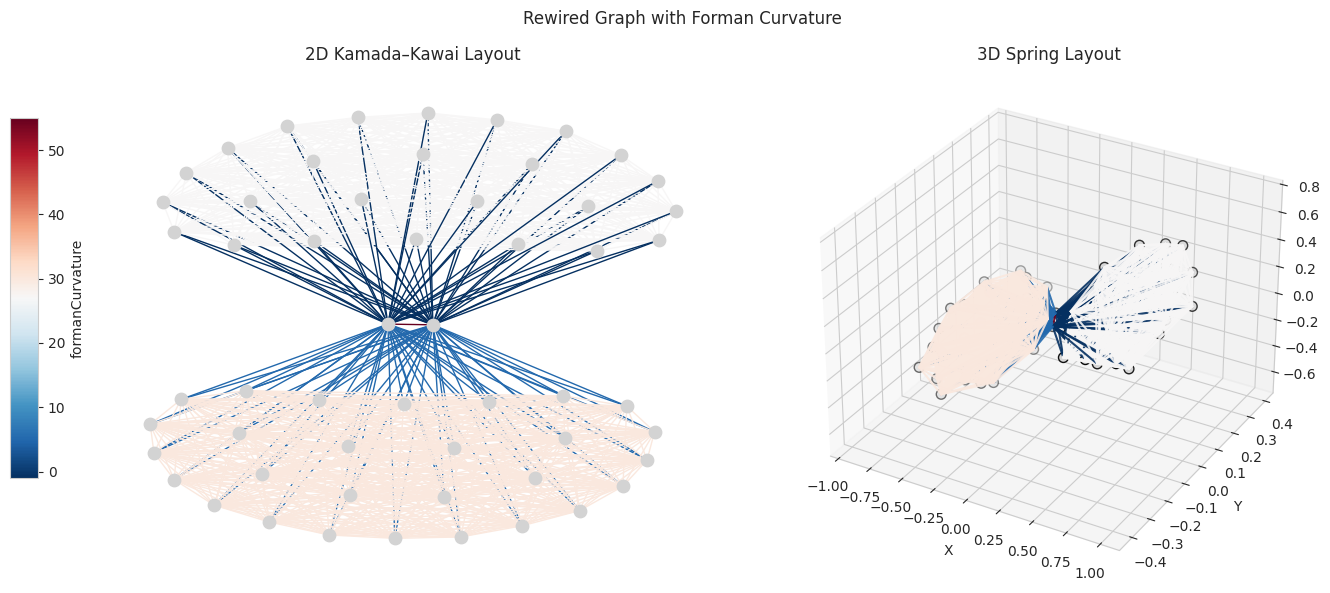


📂 Summary (Mean & Std) results saved to results/rewired_graph_avg_std_metrics_IMDB-BINARY_['SDRF'].csv.


In [15]:
from rewiring.rewiring_call import *
from tqdm import tqdm

# dataset_names = ["REDDIT-BINARY", "IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
# dataset_names = ["IMDB-BINARY", "MUTAG", "ENZYMES", "PROTEINS"]
#                   0              1            2         3           4
# dataset_names = dataset_names[2]

# REWIRING_METHOD = ["BORF","SDRF", "FOSR", "LASER", "UNREWIRED"]
# REWIRING_METHOD = ["BORF","SDRF", "FOSR", "DES","PPR", "LASER", "UNREWIRED"]
# #                   0       1       2       3      4      5         6
# REWIRING_METHOD = REWIRING_METHOD[0]

dataset_loader = GraphDatasetLoader(dataset_names)
loaded_datasets = dataset_loader.get_loaded_dataset_names()

all_metrics_df = []
all_curvature = []
all_rewired_graphs_curv = []
all_unrewired_graphs_curv = []
all_curvature_unrewired = []
diff_measures = []
graph_curvature = {method: [] for method in REWIRING_METHOD}

edge_stats = {}

graphs_dict = {method: [] for method in REWIRING_METHOD}


for dataset_name in loaded_datasets:
    
    edge_stats[dataset_name] = {method: [] for method in REWIRING_METHOD}
    curvature_dict = {method: [] for method in REWIRING_METHOD}
    for rewiring_name in REWIRING_METHOD:
        print("Rewiring methods being used:", rewiring_name)
        print(f"\n🚀 Processing dataset: {dataset_name}")
        
        if not ENTIRE_GRAPH:  
            graphs = dataset_loader.first_graphs[dataset_name]
        else:
            graphs = dataset_loader.datasets[dataset_name]  # Load full dataset
            
        for graph in tqdm(graphs):
            
            graph_copy = graph.clone()
            
            if isinstance(graphs, torch_geometric.data.data.Data):
                rewiring_method = rewiring_call(graphs, dataset_name)
            else:
                rewiring_method = rewiring_call(graph, dataset_name)
            
            if rewiring_name == "BORF":
                rewired_graph = rewiring_method.borf_rewiring()
            elif rewiring_name == "SDRF":
                rewired_graph = rewiring_method.sdrf_rewiring()
            elif rewiring_name == "FOSR":
                rewired_graph = rewiring_method.fosr_rewiring()
            elif rewiring_name == "LASER":
                rewired_graph = rewiring_method.laser_rewiring()
            elif rewiring_name == "DES":
                rewired_graph = rewiring_method.des_rewiring(dataset_loader)
            elif rewiring_name == "PPR":
                rewired_graph = rewiring_method.ppr_rewiring()
            elif rewiring_name == "UNREWIRED":
                G_nx = to_networkx(graph, to_undirected=True)  # Convert PyG graph to NetworkX
                rewired_graph = G_nx
            else:
                raise ValueError(f"Invalid rewiring method: {rewiring_name}")
            
            pct_added, pct_removed = removed_added_edges_eval(graph_copy, rewired_graph,loaded_datasets=loaded_datasets,rewiring_method=REWIRING_METHOD, edge_stats_dict=edge_stats, eval=False)
                    
            # Compute metrics for the rewired graph
            metrics_rewired = GraphMetrics(rewired_graph, dataset_name)
            df_metrics, curv_G = metrics_rewired.get_forman() # just for forman
            # df_metrics, curv_G = metrics_rewired.get_orc()
            # df_metrics = metrics_rewired.get_eff_res_compa()
            # df_metrics = metrics_rewired.get_all_metrics()
            
            df_metrics = pd.DataFrame([df_metrics]) 
            df_metrics["Rewiring Method"] = rewiring_name
            df_metrics["Dataset"] = dataset_name
            
            curv_diff, curvatures, curv_G_unrewired, curvature_unrewired, curvature_name = extract_curvature(curv_G, graph, dataset_name)

            diff_measures.append(curv_diff)
            
            # Store and later save the metrics
            all_metrics_df.append(df_metrics)
            curvature_dict[rewiring_name].extend(curvatures)
            all_curvature.extend(curvatures)  # Extend list with all edges' curvature
            all_curvature_unrewired.extend(curvature_unrewired)
            all_rewired_graphs_curv.append(curv_G)
            all_unrewired_graphs_curv.append(curv_G_unrewired)
            edge_stats[dataset_name][rewiring_name].append((pct_added, pct_removed))
            graphs_dict[rewiring_name].append(rewired_graph)
    
    # plot_degree_dist(graphs_dict, dataset_name)

df = removed_added_edges_eval(graph_copy,rewired_graph,loaded_datasets=loaded_datasets,rewiring_method=REWIRING_METHOD, edge_stats_dict=edge_stats, eval=True) 

# Done collecting. Now pick the index of the max difference
if diff_measures:
    idx_best = int(np.argmax(diff_measures))
    print("Index with largest curvature difference:", idx_best, "difference=", diff_measures[idx_best])

    # Now let's plot the histogram or the single best example:
    if show:
        # plot_curv_histogram_compare(curvature_dict, "UNREWIRED", "LASER")

        plot_curv_histogram(all_curvature, name=curvature_name)

        # Plot the biggest-difference example
        best_unrewired = all_unrewired_graphs_curv[idx_best]
        best_rewired   = all_rewired_graphs_curv[idx_best]

        rewiring_method_UN = "UNREWIRED"
        
        plot_graph_curvature_subplots(
            best_unrewired,
            curvature_name=curvature_name,
            title="Unrewired Graph with Forman Curvature",
        )
        
        # Then do the same for a rewired version:
        plot_graph_curvature_subplots(
            best_rewired,
            curvature_name=curvature_name,
            title="Rewired Graph with Forman Curvature",
        )
                   

# Convert results to DataFrame
final_df = pd.concat(all_metrics_df, ignore_index=True)

# Compute mean and standard deviation, excluding non-numeric columns
if ENTIRE_GRAPH:
    numeric_cols = final_df.select_dtypes(include=["number"])  
    avg_metrics = numeric_cols.mean().to_frame(name="Mean")  
    std_metrics = numeric_cols.std().to_frame(name="Std")  

    # Combine into a single DataFrame
    summary_df = pd.concat([avg_metrics, std_metrics], axis=1)

    # Format the output to display mean ± std in a single column
    summary_df["Formatted"] = summary_df.apply(lambda row: f"{row['Mean']:.6f} ± {row['Std']:.6f}", axis=1)

    # Save summary results correctly
    summary_output_csv = f"results/rewired_graph_avg_std_metrics_{dataset_name}_{REWIRING_METHOD}.csv"
    parent = Path(summary_output_csv).parent
    os.makedirs(parent, exist_ok=True)
    
    # If the path exists remove it
    if os.path.exists(summary_output_csv):
        os.remove(summary_output_csv)
    summary_df.to_csv(summary_output_csv, index=True)

    print(f"\n📂 Summary (Mean & Std) results saved to {summary_output_csv}.")
else:
    # Save individual rewiring results
    output_csv = f"results/rewired_graph_metrics_{dataset_name}.csv"
    # make sure the directory exists
    parent = Path(output_csv).parent
    os.makedirs(parent, exist_ok=True)
    
    final_df.to_csv(output_csv, index=False)
    print(f"\n📂 All rewiring results saved to {output_csv}.")